In [ ]:
#Define execfile for python3
# def execfile(filepath, globals=None, locals=None):
#     if globals is None:
#         globals = {}
#     globals.update({
#         "__file__": filepath,
#         "__name__": "__main__",
#     })
#     with open(filepath, 'rb') as file:
#         exec(compile(file.read(), filepath, 'exec'), globals, locals)

In [8]:
#Shows each individual plot along with which model best fits it
import pickle, math
import pandas as pd
import sqlite3
import random
import os
import itertools
exec(open('Imports.py').read()) #execfile('Imports.py')
import Modules.Funcs as funcs
from Modules.Classes import Simulation
from Modules.Classes import CopyTweak
from Modules.Classes import CopyTweakRep
from Modules.Classes import Packer
from Modules.Classes import PackerRep
from Modules.Classes import PackerEuc
from Modules.Classes import ConjugateJK13
from Modules.Classes import RepresentJK13
from scipy.stats import stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#plotting options
STAT_LIMS =  (-1.0, 1.0)
#Fit to only last trial?
fitlast = False
#Make plots?
doplots = False
saveplots = False
if fitlast:
    showlast = True
else:
    showlast = False #True = Show last even if fitting to all?
#Bootstrap parameters
nbootstraps = 1000

# if fitlast and showlast:
#     savedir = 'private/individual_modelcomp/fitlast'
# elif showlast:
#     savedir = 'private/individual_modelcomp/showonlylast/'
# elif fitlast:
#     savedir = 'private/individual_modelcomp/fitlast'
# else:
#     savedir = 'private/individual_modelcomp/showall'

# savefilename='modelvsppt{}_t.pdf'.format(corrtype)
# modeleaseDB = "pickles/modelease_corr{}.p".format(corrtype)

#Some plotting options
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 15}

#Specify simulation values
N_SAMPLES = 10000
WT_THETA = 1.5
MIN_LL = 1e-10

# Specify default dataname
dbname = 'experiments-5con.db'#'experiments-5con.db'#raw data
dataname_def = '5con'#'5con'#bestparms comes from here

# Specify default dataname
# dataname_def = 'pooled'#'nosofsky1986'#'NGPMG1994'
participant_def = 'all'
unique_trials_def = 'all'
dataname = dataname_def
execfile('validate_data.py')

bestparmdb = "pickles/chtc_gs_best_params_{}".format(src)


plt.rc('font', **font)

# get data from pickle
with open(pickledir+src, "rb" ) as f:
    trials = pickle.load( f )

# get best params pickle
#bestparmdb = "pickles/chtc_gs_best_params_all_data_e1_e2.p"
#bestparmdb = "pickles/chtc_gs_best_params_corrs.p"
with open(bestparmdb, "rb" ) as f:
    best_params_t = pickle.load( f )

#Rebuild it into a smaller dict
best_params = dict()
for modelname in best_params_t.keys():    
    best_params[modelname] = dict()
    for i,parmname in enumerate(best_params_t[modelname]['parmnames']):
        parmval = best_params_t[modelname]['bestparmsll']
        best_params[modelname][parmname] = parmval[i]
modelList = [Packer,RepresentJK13,ConjugateJK13]
#modelList = [CopyTweak,CopyTweakRep,Packer, RepresentJK13,]                            

#Specify plot order
modelPlotOrder = np.array([[Packer,RepresentJK13],[CopyTweak,ConjugateJK13]])
#modelPlotOrder = np.array([[CopyTweak,CopyTweakRep],[Packer,RepresentJK13]])

#Prepare matched database    
# matchdb='../cat-assign/data_utilities/cmp_midbot.db'
        
unique_trials = 'all'
trials.task = task




In [9]:
#Create new trialset
con = sqlite3.connect(dbname)
participants = pd.read_sql_query("SELECT participant, condition from participants", con)
generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()

# create categories mapping                                                                             
mapping = pd.DataFrame(columns = ['condition', 'categories'])
for i in alphas.columns:
    As = alphas[i].values.flatten()
    mapping = mapping.append(
        dict(condition = i, categories =[As]),
        ignore_index = True
    )

# merge categories into generation                                                                      
generation = pd.merge(generation, participants, on='participant')
generation = pd.merge(generation, mapping, on='condition')
#Select only one participant
def generateOnePerm(ppt,generation,stimuli,order=None,betas=None,alphas=None):
    genppt = generation.loc[generation.participant==ppt]
    if order is None:
        order = genppt.trial
    if betas is None:
        betas = genppt.stimulus
    minlength = min(len(order),len(betas))
    while len(genppt)<minlength:
        temprow = genppt.iloc[0]
        genppt = genppt.append({'participant':temprow.participant,'stimulus':temprow.stimulus,'trial':max(genppt.trial)+1,'condition':temprow.condition,'categories':temprow.categories},ignore_index=True)
    if alphas is None:
        categories = genppt.categories
    else:
        categories = [[alphas] for i in range(minlength)]
    #Extract only as much as the minimum specified order or beta allows
    genppt = genppt[0:minlength]
    genppt.trial = order[0:minlength]
    genppt.stimulus = betas[0:minlength]
    genppt.categories = categories[0:minlength]

  
    # create trial set object                                                                               
    trials = Simulation.Trialset(stimuli)
    trials = trials.add_frame(genppt)
    trials.task = 'generate'
    trials._update
    return trials

In [10]:
##Plotting function
def plotInd(ppts,betas=None,alphas=None,order=None,doplots=True):
    #Go through each participant and get their fits for each model
    nmodels = len(modelList)
    ll = []
    tally = np.zeros(nmodels)
    wins = []
    true_order = np.bool_(np.zeros(len(ppts)))
    for ppi,ppt in enumerate(ppts):#[147]:#trials.participants:
        ppt = int(ppt)
#         print('Ppt: ' + str(ppt))
        llrow = []
        if fitlast:
            extract_trials = 3
        else:
            extract_trials = 'all'
        pptconstr = participants.condition[participants.participant==ppt].values[0][0]
        raw_order = generation.loc[generation.participant==ppt].trial.values        
        true_order[ppi] = np.array_equal(raw_order,order)
        trialppt = generateOnePerm(ppt,generation,stimuli,order=order,betas=betas, alphas=alphas)
    #     trialppt = Simulation.extractPptData(trials, ppt=ppt, unique_trials=extract_trials)
        #Get list of lls and winning model
        for model in modelList:
            if model is PackerEuc: #Gotta do this because I haven't fit PackerEuc to all data yet
                params = best_params[Packer.model]
            else:
                params = best_params[model.model]
            ppt_trial_ll = trialppt.loglike(params=params,model=model,parmxform=False)
            llrow += [ppt_trial_ll]
        bestmodel = llrow.index(np.min(llrow))
        bestmodelstr = modelList[bestmodel].modelshort
        ll += [[ppt]+llrow]
        tally[bestmodel] += 1
        wins += [bestmodel]
        #Prepare stuff fot plotting
        if doplots:

            #Sort trial obj by trial number - really only applicable if onlylast is false                                                                                                                   
            trialOrder = []
            maxbeta = 0
            for t,trialobj in enumerate(trialppt.Set):
                nbeta = len(trialobj['categories'][1])
                trialppt.Set[t]['trial'] = nbeta
                trialOrder += [nbeta]
                maxbeta = max(nbeta,maxbeta)
            trialOrder = np.argsort(trialOrder)
            wrap_ax = trialppt.Set[0]['wrap_ax'][0]
            if wrap_ax==1:
                wrapstr = '<-Wrapped->'
            else:
                wrapstr = ''
            #Add dummy last trial to plot gradients for hypothetical fifth beta
            newcatB = np.append(trialppt.Set[trialOrder[maxbeta]]['categories'][1],trialppt.Set[trialOrder[maxbeta]]['response'])
            newcatAll = [trialppt.Set[trialOrder[maxbeta]]['categories'][0],newcatB]
            trialppt.add(response=0,categories=newcatAll, participant = ppt,wrap_ax = wrap_ax)
            trialOrder = np.append(trialOrder,maxbeta+1)
            if showlast:
                ntrials = 1
                plottrials = [len(trialppt.Set)-1] #plot only last trial
            else:
                ntrials = len(trialppt.Set)
                plottrials = range(ntrials)
            f,ax = plt.subplots(ntrials,nmodels,figsize = (4*nmodels, 2*ntrials+2.5))
            for trial in plottrials:
                categories = [trialppt.stimuli[i,:] for i in trialppt.Set[trialOrder[trial]]['categories'] if len(i)>0]
                A = categories[0]
                resp = trialppt.stimuli[trialppt.Set[trialOrder[trial]]['response'],:]
                if len(categories)>1:
                    #include the response                                                                                                                  
                    B = np.append(categories[1],resp,axis=0)
                    if showlast:
                        #Include response in generatin of ps                
                        categories[1] = B
                else:
                    #categories += [resp]
                    B = resp            
                ps = []
                ll_trial = []
                for m,model in enumerate(modelList):
                    if m==bestmodel:
                        winstr = '*'
                    else:
                        winstr = ''
                    if ntrials>1:
                        ax[0,m].set_title('{}{}{}, ll={:.2f}'.format(winstr,model.modelshort,winstr,llrow[m]))
                    else:                    
                        ax[m].set_title('{}{}{}, ll={:.2f}'.format(winstr,model.modelshort,winstr,llrow[m]))
                    if model is PackerEuc: #Gotta do this because I haven't fit PackerEuc to all data yet
                        params = best_params[Packer.model]
                    else:
                        params = best_params[model.model]
                    #Plot heatmap for each model
                    ps += [model(categories,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate',wrap_ax=wrap_ax)]
                    #Get lls for each trial step
                    ll_trial += [trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True)]


                #Plot the individual plots
                plotct = 0
                plotVals = []
                psMax = 0
                psMin = 1
                #Get range                                                                                                                                     
                for ps_el in ps:
                    psMax = max(psMax,ps_el.max())
                    psMin = min(psMin,ps_el.min())

                #Normalise all values                                                                                                                          
                psRange = psMax-psMin
                for i,ps_el in enumerate(ps): #each ps element correspond to a model
                    plotct += 1
                    gps = funcs.gradientroll(ps_el,'roll')[:,:,0]
                    ps_ElRange = gps.max()-gps.min();
    #                 if ps_ElRange==0:
    #                     ps_ElRange = 1
                    plotVals += [(gps-gps.min())/ps_ElRange]  #Change ps_ElRange to psRange to normalize across all models                                                                           
                    betacol = ['green' for bi in range(len(B))]
    #                 if task is 'generate':
    #                     betacol[len(B)-1] = 'orange'
                    if ntrials>1:
                        betacol[len(B)-1] = 'orange'
                        if trial == ntrials-1:
                            betacol[len(B)-1] = [0,0,0,0]
                        im = funcs.plotgradient(ax[trial,i], plotVals[i], A, B, clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
                        ax[trial,i].set_ylabel('Trial {}\n{}'.format(trial,wrapstr))
                        if trial<ntrials-1:
                            ax[trial,i].set_xlabel('ll_trial = {:.2f}'.format(ll_trial[i][trial]),fontsize=10)
                        #else:

                    else:
                        im = funcs.plotgradient(ax[i], plotVals[i], A, B, clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
    #                     ax[i].set_ylabel('Trial {}'.format(trial))
            #Save fig
            if saveplots:
                savedirext = '{}/{}'.format(savedir,bestmodelstr)
                if os.path.isdir(savedirext):
                    plt.savefig('{}/{}_{}_{}'.format(savedirext,pptconstr,int(ppt),bestmodelstr[0]))
                else:
                    os.mkdir(savedirext)
                    plt.savefig('{}/{}_{}_{}'.format(savedirext,pptconstr,int(ppt),bestmodelstr[0]))
    #         plt.close()

    return ll,wins,true_order


In [11]:
generation

,category,participant,stimulus,trial,wrap_ax,condition,categories
0,None,0,73,1,NaN,Cluster,"[[14, 16, 32, 34]]"
1,None,0,72,0,NaN,Cluster,"[[14, 16, 32, 34]]"
2,None,0,64,3,NaN,Cluster,"[[14, 16, 32, 34]]"
3,None,0,63,2,NaN,Cluster,"[[14, 16, 32, 34]]"
4,None,2,73,1,NaN,Cluster,"[[14, 16, 32, 34]]"
5,None,2,78,0,NaN,Cluster,"[[14, 16, 32, 34]]"
6,None,2,80,3,NaN,Cluster,"[[14, 16, 32, 34]]"
7,None,2,76,2,NaN,Cluster,"[[14, 16, 32, 34]]"
8,None,3,0,1,NaN,Cluster,"[[14, 16, 32, 34]]"
9,None,3,72,0,NaN,Cluster,"[[14, 16, 32, 34]]"


In [12]:
tempt = generateOnePerm(10,generation,stimuli)
tempt.Set

[{'categories': [array([ 0, 10, 70, 80]), array([], dtype=int64)],
  'participant': array([10]),
  'response': array([8]),
  'wrap_ax': array([None], dtype=object)},
 {'categories': [array([ 0, 10, 70, 80]), array([8])],
  'participant': array([10]),
  'response': array([80]),
  'wrap_ax': array([None], dtype=object)},
 {'categories': [array([ 0, 10, 70, 80]), array([ 8, 80])],
  'participant': array([10]),
  'response': array([71]),
  'wrap_ax': array([None], dtype=object)},
 {'categories': [array([ 0, 10, 70, 80]), array([ 8, 71, 80])],
  'participant': array([10]),
  'response': array([62]),
  'wrap_ax': array([None], dtype=object)}]

/Users/sourguyxian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in divide


([[318, 3.564123809318619, 4.922866076432691, 4.394449154672439]],
 [0],
 array([False]))

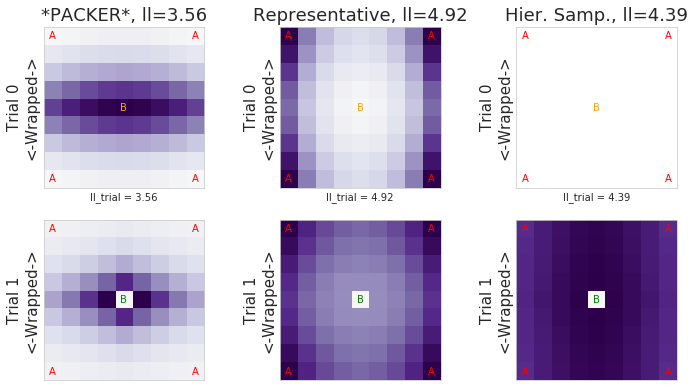

In [15]:
ppts = [318]#318#trials.participants:
betas = [40]#[40,31,49,39,41]#[30,32,48,50]#[72,64,16,8]#[30,32,48,50]
alphas = None#[40,64,70,16]#[68,60,52]
modelList = [Packer,RepresentJK13,ConjugateJK13]
if betas is None:
    nbetas = 4
else:
    nbetas = len(betas)
order = None#[2,3,1,0] #None: ordered by participant
plotInd(ppts,betas,alphas,order,doplots=True)

/Users/sourguyxian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in divide


([[10, 7.092610043442002, 4.100824739348411, 4.394449154672439]],
 [1],
 array([False]))

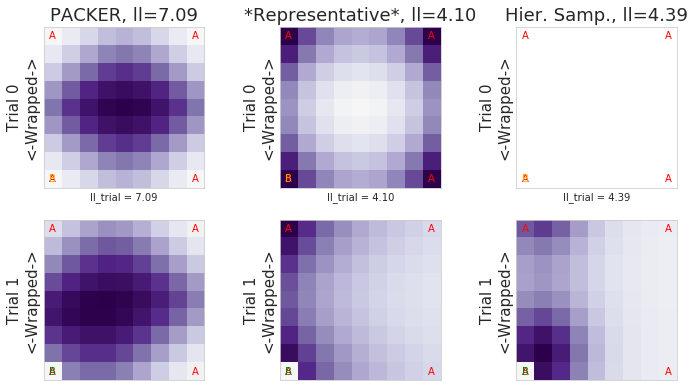

In [31]:
ppts = [10]#[101]#[318]#trials.participants:
betas = [0]#[39,41,49,31]#midcross#[2,3,4,5]#centered[39,41,49,31]#[30,32,48,50]#[72,64,16,8]#[30,32,48,50]
alphas = [0,8,72,80]#oneoff[10,64,70,16]#edge[0,8,72,80]#[40,64,70,16]#[68,60,52]
# modelList = [Packer,RepresentJK13,ConjugateJK13]
if betas is None:
    nbetas = 4
else:
    nbetas = len(betas)
order = range(nbetas) #None = ordered by participant
plotInd(ppts,betas,alphas,order,doplots=True)

In [ ]:
#See if wins are consistent across permutations?)
ppts = trials.participants
betas = None#[40,31,49,39,41]#[30,32,48,50]#[72,64,16,8]#[30,32,48,50]
alphas = None#[40,64,70,16]#[68,60,52]
if betas is None:
    nbetas = 4
else:
    nbetas = len(betas)
# order = [2,3,1,0] #None: ordered by participant
trialPerms = list(itertools.permutations(range(4)))
modelList = [Packer,RepresentJK13]
wins_all = []
wins_true = np.zeros(len(ppts))
for pi,perm in enumerate(trialPerms):
    print(pi)
    res = plotInd(ppts,betas,alphas,perm,doplots=False)
    wins = np.array(res[1]    )
    wins_true[res[2]] = wins[res[2]]
    wins_all += [wins]

wins_sum = np.sum(np.array(wins_all),axis=0)


In [ ]:
wins_check = np.round(wins_sum/24.) == wins_true
#list(np.array((wins_check,ppts,wins_sum, wins_true)).T)
checkfail = ppts[wins_check==False]
print(list(checkfail))
print(len(checkfail))

In [ ]:
plt.hist(np.sum(np.array(wins_all),axis=0))

In [ ]:
##260319 this code block was an attempt at trying to plot all 24 permutations of the 4 betas, but probably isn't feasible 
## or as informative as I'd like. Abandoning this attempt now.
#Go through each participant and get their fits for each model
ll = []
tally = np.zeros(2)
wins = []
permrange = 4
trialPerms = list(itertools.permutations(range(permrange)))    
for ppt in [26]:#trials.participants:
    ppt = int(ppt)
    print('Ppt: ' + str(ppt))
    llrow = []
    if fitlast:
        extract_trials = 3
    else:
        extract_trials = 'all'
    f,ax = plt.subplots(ntrials*4,len(modelList)*6,figsize = (8, 2*ntrials+2.5))
    for pi,perm in enumerate(trialPerms):        
        trialppt = generateOnePerm(ppt,perm,generation,stimuli)
        #trialppt = Simulation.extractPptData(trials, ppt=ppt, unique_trials=extract_trials)
        #Get list of lls and winning model
        for model in modelList:
            params = best_params[model.model]
            ppt_trial_ll = trialppt.loglike(params=params,model=model,parmxform=False)
            llrow += [ppt_trial_ll]
        bestmodel = llrow.index(np.min(llrow))
        bestmodelstr = modelList[bestmodel].modelshort
        ll += [[ppt]+llrow]
        tally[bestmodel] += 1
        wins += [bestmodel]
        #Prepare stuff fot plotting
        if doplots:

            #Sort trial obj by trial number - really only applicable if onlylast is false                                                                                                                   
            trialOrder = []
            maxbeta = 0
            for t,trialobj in enumerate(trialppt.Set):
                nbeta = len(trialobj['categories'][1])
                trialppt.Set[t]['trial'] = nbeta
                trialOrder += [nbeta]
                maxbeta = max(nbeta,maxbeta)
            trialOrder = np.argsort(trialOrder)
            #Add dummy last trial to plot gradients for hypothetical fifth beta
            newcatB = np.append(trialppt.Set[trialOrder[maxbeta]]['categories'][1],trialppt.Set[trialOrder[maxbeta]]['response'])
            newcatAll = [trialppt.Set[trialOrder[maxbeta]]['categories'][0],newcatB]
            trialppt.add(response=0,categories=newcatAll, participant = ppt)
            trialOrder = np.append(trialOrder,maxbeta+1)

            if showlast:
                ntrials = 1
                plottrials = [len(trialppt.Set)-1] #plot only last trial
            else:
                ntrials = len(trialppt.Set)
                plottrials = range(ntrials)
            for trial in plottrials:
                categories = [trialppt.stimuli[i,:] for i in trialppt.Set[trialOrder[trial]]['categories'] if len(i)>0]
                A = categories[0]
                resp = trialppt.stimuli[trialppt.Set[trialOrder[trial]]['response'],:]
                if len(categories)>1:
                    #include the response                                                                                                                  
                    B = np.append(categories[1],resp,axis=0)
                    if showlast:
                        #Include response in generatin of ps                
                        categories[1] = B
                else:
                    #categories += [resp]
                    B = resp            
                ps = []
                ll_trial = []
                for m,model in enumerate(modelList):
                    plotcol = pi*4+m
                    plotrow = 
                    if m==bestmodel:
                        winstr = '*'
                    else:
                        winstr = ''
                    if ntrials>1:
                        ax[0,plotcol].set_title('{}{}{}, ll={:.2f}'.format(winstr,model.modelshort,winstr,llrow[m]))
                    else:                    
                        ax[plotcol].set_title('{}{}{}, ll={:.2f}'.format(winstr,model.modelshort,winstr,llrow[m]))
                    params = best_params[model.model]
                    #Plot heatmap for each model
                    ps += [model(categories,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate')]
                    #Get lls for each trial step
                    ll_trial += [trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True)]


                #Plot the individual plots
                plotct = 0
                plotVals = []
                psMax = 0
                psMin = 1
                #Get range                                                                                                                                     
                for ps_el in ps:
                    psMax = max(psMax,ps_el.max())
                    psMin = min(psMin,ps_el.min())

                #Normalise all values                                                                                                                          
                psRange = psMax-psMin
                for i,ps_el in enumerate(ps): #each ps element correspond to a model
                    plotcol = pi*4+i
                    plotct += 1
                    gps = funcs.gradientroll(ps_el,'roll')[:,:,0]
                    ps_ElRange = gps.max()-gps.min();
                    plotVals += [(gps-gps.min())/ps_ElRange]                                                                             
                    betacol = ['green' for bi in range(len(B))]
    #                 if task is 'generate':
    #                     betacol[len(B)-1] = 'orange'
                    if ntrials>1:
                        betacol[len(B)-1] = 'orange'
                        if trial == ntrials-1:
                            betacol[len(B)-1] = [0,0,0,0]
                        im = funcs.plotgradient(ax[trial,i], plotVals[i], A, B, clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
                        ax[trial,plotcol].set_ylabel('Trial {}'.format(trial))
                        if trial<ntrials-1:
                            ax[trial,plotcol].set_xlabel('ll_trial = {:.2f}'.format(ll_trial[i][trial]),fontsize=10)
                        #else:

                    else:
                        im = funcs.plotgradient(ax[plotcol], plotVals[i], A, B, clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
    #                     ax[i].set_ylabel('Trial {}'.format(trial))
            #Save fig
            savedirext = '{}/{}'.format(savedir,bestmodelstr)
            if os.path.isdir(savedirext):
                pass
    #             plt.savefig('{}/{}_{}'.format(savedirext,int(ppt),bestmodelstr[0]))
            else:
                pass
    #             os.mkdir(savedirext)
    #             plt.savefig('{}/{}_{}'.format(savedirext,int(ppt),bestmodelstr[0]))
    lll

    


In [ ]:
ppt

In [ ]:
#Print a summary
print('Tally of bests:')

for m,model in enumerate(modelList):
    print('%s: %.2f' % (model.modelshort,tally[m]))

In [ ]:
trialppt.Set

In [ ]:
trialppt.Set[len(trialppt.Set)-1]['categories']

In [ ]:
temp= cp.deepcopy(trialppt)
newcatB = np.append(temp.Set[len(trialppt.Set)-1]['categories'][1],temp.Set[len(trialppt.Set)-1]['response'])
newcatAll = [temp.Set[len(trialppt.Set)-1]['categories'][0],newcatB]
temp.add(response=np.array([0,0]),categories=newcatAll, participant = ppt)

In [ ]:
trialppt.loglike(params=params,model=model,parmxform=False,whole_array=False)

In [ ]:
sum(trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True))

In [ ]:
trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True)

In [ ]:
newcatAll

In [ ]:
maxbeta

In [ ]:
trialOrder